# Experiment 1 Fixed Tilt with Varying Parameters

This journal supports the process of designing a solar panel configuration to appropriately represent and Agripv setup with varying parameters.
The goal of this journal is to test and compare the irradiance values when changing certain parameters. Only one paramater is changed at a time. 
The journal also uses these Radiance results to compare them to results calculated for the same parameters for bifacialVF, calculating accuracy as a percent difference.
(<a href="http://localhost:8888/notebooks/Documents/GitHub/bifacialvf/docs/tutorials/Bifacialvf_Experiment_1.ipynb">Bifacialvf_Experiment_1</a>)

Details:
*	Location: lat = 32.25, -110.9 (Tuscon, Arizona)
*	Racking: Fixed-tilt panels
*	Panel size: 1m x 2m                                    
*	Analysis variations:
<ul> <li> a.	Panel tilt: would like to examine angles 20,30 degrees. 
<li> b.	Clearance Height: would like to look at multiple heights ([0.25, 0.5, 0.75, 1, 1.5, 2 m) </li> 
<li> c.	Ground Coverage Ratio (GCR) (E/W): would like to look at multiple GCRs (0.28, 0.33, 0.4, 0.6) </li> 
<li> d. Ygaps: Looking at multiple Ygaps in the modules. (0,.1,.2,.3,.5,1) </li>


In [2]:
import bifacial_radiance
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bifacialvf

In [3]:
testfolder = str(Path().resolve().parent.parent / 'bifacial_radiance' / 'TEMP' /  'Experiment_1')
if not os.path.exists(testfolder):
    os.makedirs(testfolder)
    
resultsfolder = os.path.join(testfolder, 'results')

### General Parameters and Variables

In [4]:
ft2m = 0.3048
lat = 32.25
lon = -110.9  #Lat and Long for Tuscon Arizona           

# Constants
azimuth = 180 #cycling through 3 different azimuths                 
albedo = 0.31  # Changed from 0.31 for test 6/9/22
x = 1
y = 2 
xgap =  0.02
ygap = 0 # Meters
# D (meters)is a variable that represents the spacing between rows, not-considering the collector areas.
D = 2.8        
nMods = 20
nRows = 7
numpanels = 1
moduletype = 'test-module' #Need to make sure this is right module
hpc = False
sim_general_name = 'Rad_Experiment1'
CW = y * numpanels
    
#Arrays for loops
tilts = [20,30]  
clearance_heights = np.array([0.25,0.5,0.75,1,1.5,2]) # height/ collector width
GCRs = [0.28,0.33,0.4,0.6]

#Defaults
tilt_def = tilts[0]
clearance_height_def = clearance_heights[2]
GCR_def = GCRs[1]
pitch_def = CW/GCR_def



6.0606060606060606


## Create Geometry using gendaylit and view

In [7]:
# This allows us to view how our setup looks before generating the cumulative sky and running the simulation.
# Exit out of the popup to be able to comntinue.
demo = bifacial_radiance.RadianceObj(sim_general_name,str(testfolder)) 
demo.setGround(albedo)
epwfile = demo.getEPW(lat,lon)  
metdata=demo.readWeatherFile(epwfile, starttime=starttime, endtime=endtime)
timestamp = metdata.datetime.index(pd.to_datetime('2003-06-01 13:00:0 -8'))
demo.gendaylit(timestamp)  # Use this to simulate only one hour at a time.
azimuth_test = 180
pitch = pitch_def
sim_name = sim_general_name+'_az_'+str(round(azimuth,1))
module = demo.makeModule(name=moduletype, x=x, y=y,numpanels = numpanels, xgap=xgap, ygap=ygap)
sceneDict = {'tilt':tilt_def,'pitch':pitch,'clearance_height':clearance_height_def,'azimuth':azimuth_test,'nMods': nMods,'nRows': nRows}
scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
octfile = demo.makeOct(demo.getfilelist()) 
!rvu -vf views\front.vp -e .01 -pe 0.4 -vp 3.5 -20 22 Rad_Experiment1.oct

path = C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1
Loading albedo, 1 value(s), 0.310 avg
1 nonzero albedo values.
Getting weather file: USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2003
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos

Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct


## Generate Sky for a month

In [8]:
starttime =pd.to_datetime('2021-6-01 01:00:0')
endtime = pd.to_datetime('2021-6-30 23:00:0')
demo = bifacial_radiance.RadianceObj(sim_general_name,str(testfolder)) 
demo.setGround(albedo)
epwfile = demo.getEPW(lat,lon)  
demo.readWeatherFile(epwfile, starttime=starttime, endtime=endtime, coerce_year = 2021) # Name and path
demo.genCumSky()


path = C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1
Loading albedo, 1 value(s), 0.310 avg
1 nonzero albedo values.
Getting weather file: USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw
 ... OK!
8760 line in WeatherFile. Assuming this is a standard hourly WeatherFile for the year for purposes of saving Gencumulativesky temporary weather files in EPW folder.
Coercing year to 2021
Filtering dates
Saving file EPWs\metdata_temp.csv, # points: 8760
Calculating Sun position for Metdata that is right-labeled  with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Loaded  EPWs\metdata_temp.csv
message: There were 418 sun up hours in this climate file
Total Ibh/Lbh: 0.000000


'skies\\cumulative.rad'

## Setup length, width and sensors for scene

In [9]:
# Parameters for scene size and sensor starts
sensorsx_fb = [1,1]
sensorsy_fb = [4,6*numpanels]
sensorsx_gb = [1,1] 
sensorsy_gb = [200,198] 

## Begining of Experiment. Part 1: Varying tilt

In [10]:
module = demo.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
for ti in range (0, len(tilts)):
    #Build scene and run raytracing for both tilts
    tilt = tilts[ti]
    length = pitch_def*nRows+(y* np.cos(np.radians(tilt)))+2
    yinc = pitch_def/(sensorsy_gb[0]-1)
    writefiletitle = os.path.join(testfolder, 'Results_Test_Tilt_'+str(tilt)+'.csv')
    sim_name = sim_general_name+'_tilt_'+str(tilt)
    sceneDict = {'tilt':tilt,'pitch':pitch_def,'clearance_height':clearance_height_def,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb)
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)
    


Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_tilt_20_Module_Analysis_Front
Linescan in process: Rad_Experiment1_tilt_20_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_tilt_20_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_tilt_20_Module_Analysis_Back.csv
Linescan in process: Rad_Experiment1_tilt_20_Ground_Analysis_Front
Linescan in process: Rad_Experiment1_tilt_20_Ground_Analysis_Back
Saved: results\irr_Rad_Experiment1_tilt_20_Ground_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_tilt_20_Ground_Analysis_Back.csv
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_tilt_30_Module_Analysis_Front
Linescan in process: Rad_Experiment1_tilt_30_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_tilt_30_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_til

## Ground Irradiance Tilt Comparison Graphs

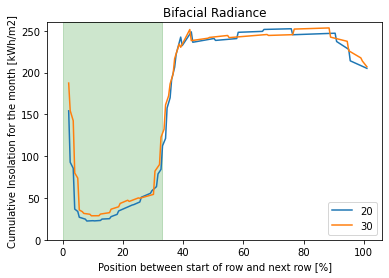

In [11]:
for ti in range (0, len(tilts)):
    tilt = tilts[ti]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_'+str(tilt)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2
    #Flip the table that contains the data
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch_def)*100
    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=tilt)
    plt.title('Bifacial Radiance')
    plt.ylim([0, 260])
    #Based on the length of the module and the pitch, in this analysis the module is located from 0-33% on the axis.
    #This is marked out in green.
    plt.axvspan(0, 33, alpha=.1, color='green')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.legend()
   

## Find percent differences betweem Radiance and VF

In [14]:
# Using full width half hight calculateions to find the midpoint of both Radiance and VF graphs. Then averaging the points below the midpoint
# and comparing them to find percent differences.
for ti in range (0, len(tilts)):
    tilt = tilts[ti]
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_'+str(tilt)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 200,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >220000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    print('Rad Mid',Mid)
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #Average these for the average for Radiance
    Radave = np.mean(line['Wm2Front'])
    print('Average Radiance is',Radave)

    #Do the Same for Bifacial VF
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_Tilt_'+str(tilt)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Jun'] >220000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Jun'])
    #Find Minimum of plot
    minpointvf=np.min(df['Jun'])
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    print('VF mid',Midvf)
    Midrvf = Midvf + minpointvf
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Jun'] < Midrvf]
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Jun'])
    print('Average VF is',VFave)

    Pdif = abs((Radave-VFave)/((Radave+VFave)/2)*100)
    print('For tilt =',tilt,'difference is',Pdif,'%')

Rad Mid 110615.47521739131
Average Radiance is 44322.65703124998
VF mid 110533.8745376447
Average VF is 47121.065817739036
For tilt = 20 difference is 6.120504938562861 %
Rad Mid 107242.44291666667
Average Radiance is 49443.32899999998
VF mid 110160.27799032335
Average VF is 52612.89669961518
For tilt = 30 difference is 6.2114146939830395 %


## Back of Module Comparison

C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_20_Ground_Analysis_Back.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_30_Ground_Analysis_Back.csv


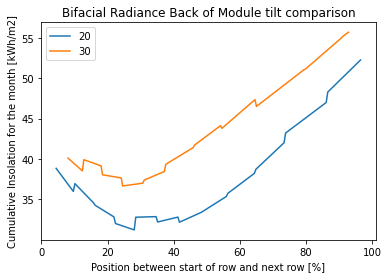

In [15]:
## Compares the irradiance that reaches the back of the module for the two tilts
for ti in range (0, len(tilts)):
    tilt = tilts[ti]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_tilt_'+str(tilt)+'_Ground_Analysis_Back.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)

    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Back",}, inplace = True) 
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/CW)*100
    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Back']/1000, label=tilt)
    plt.title('Bifacial Radiance Back of Module tilt comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.legend()

##  Part 2: Varying Clearance Height

In [16]:
module = demo.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
for ch in range (0, len(clearance_heights)):
    #Build scene and run raytracing for all clearance heights
    clearance_height = clearance_heights[ch]
    length = pitch_def*nRows+(y* np.cos(np.radians(tilt_def)))+2
    yinc = pitch_def/(sensorsy_gb[0]-1)
    writefiletitle = os.path.join(testfolder, 'Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv')
    sim_name = sim_general_name+'_ClearanceHeight_'+str(clearance_height)
    sceneDict = {'tilt':tilt_def,'pitch':pitch_def,'clearance_height':clearance_height,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt_def == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb)
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)


Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Front
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Module_Analysis_Back.csv
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Front
Linescan in process: Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Back
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_ClearanceHeight_0.25_Ground_Analysis_Back.csv
Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_ClearanceHeight_0.5_Module_Analysis_Front
Linescan in process: Rad_Expe

## Ground Irradiance Clearance Height Comparison

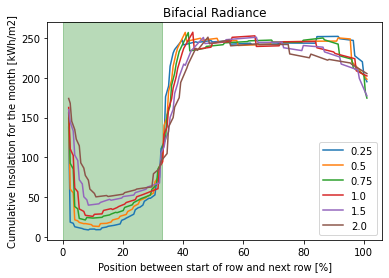

In [17]:
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True) 
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch_def)*100
    module_end = (2/pitch_def)*100 #Percentage between rows where the module ends
    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=clearance_height)
    plt.title('Bifacial Radiance')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.axvspan(0, module_end, alpha=.05, color='green')
    plt.legend()

## VF and Radiance Clearance Height Percent Differences

In [18]:
# Using full width half hight calculateions to find the midpoint of both Radiance and VF graphs. Then averaging the points below the midpoint
# and comparing them to find percent differences.
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 220,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >220000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #Average these for the average for Radiance
    Radave = np.mean(line['Wm2Front'])
    #print('Average Radiance is',Radave)

    #Do the Same for Bifacial VF
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_ClearanceHeight_'+str(clearance_height)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Jun'] >220000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Jun'])
    #Find Minimum of plot
    minpointvf=np.min(df['Jun'])
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    Midrvf = minpointvf + Midvf
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Jun'] < Midrvf]
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Jun'])
    #print('Average VF is',VFave)

    Pdif = abs((Radave-VFave)/((Radave+VFave)/2)*100)
    print('For Clearance Height =',clearance_height,'difference is',Pdif,'%')

For Clearance Height = 0.25 difference is 9.636673651889463 %
For Clearance Height = 0.5 difference is 21.86432853131734 %
For Clearance Height = 0.75 difference is 27.32095013499408 %
For Clearance Height = 1.0 difference is 24.253333427001692 %
For Clearance Height = 1.5 difference is 29.438650263841982 %
For Clearance Height = 2.0 difference is 23.1303676779576 %


## Back of Module Clearance Height Comparison

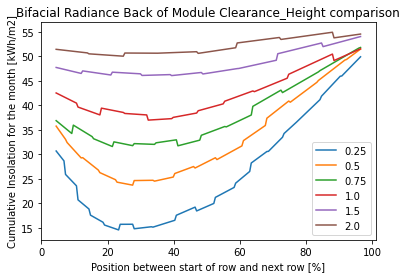

In [19]:
for ch in range (0, len(clearance_heights)):
    clearance_height = clearance_heights[ch]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_ClearanceHeight_'+str(clearance_height)+'_Ground_Analysis_Back.csv'
    (data2, metadata) = loadVFresults(Radiance_File)

    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Back",}, inplace = True) 
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/CW)*100
    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Back']/1000, label=clearance_height)
    plt.title('Bifacial Radiance Back of Module Clearance_Height comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for the month [kWh/m2]')
    plt.legend()

## Part 3 Varying GCR

In [20]:
module = demo.makeModule(name=moduletype, x=x, y=y, xgap=xgap, ygap=ygap)
for gc in range (0, len(GCRs)):
    #Build scene and run raytracing for all GCrs
    GCR = GCRs[gc]
    pitch = CW/GCR
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    yinc = pitch/(sensorsy_gb[0]-1) 
    writefiletitle = os.path.join(testfolder, 'Results_Test_GCR_'+str(GCR)+'.csv')
    sim_name = sim_general_name+'_GCR_'+str(GCR)
    sceneDict = {'tilt':tilt_def,'pitch':pitch,'clearance_height':clearance_height_def,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt_def == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb)
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)


Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_GCR_0.28_Module_Analysis_Front
Linescan in process: Rad_Experiment1_GCR_0.28_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_GCR_0.28_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_GCR_0.28_Module_Analysis_Back.csv
Linescan in process: Rad_Experiment1_GCR_0.28_Ground_Analysis_Front
Linescan in process: Rad_Experiment1_GCR_0.28_Ground_Analysis_Back
Saved: results\irr_Rad_Experiment1_GCR_0.28_Ground_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_GCR_0.28_Ground_Analysis_Back.csv
Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_GCR_0.33_Module_Analysis_Front
Linescan in process: Rad_Experiment1_GCR_0.33_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_GCR_0.33_Module_Analysis_Front.csv

## Ground Irradiance GCR Comparison Graphs

C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.28_Ground_Analysis_Front.csv
53.87938524157182
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.33_Ground_Analysis_Front.csv
46.30362766581424
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.4_Ground_Analysis_Front.csv
38.87938524157182
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.6_Ground_Analysis_Front.csv
27.212718574905153


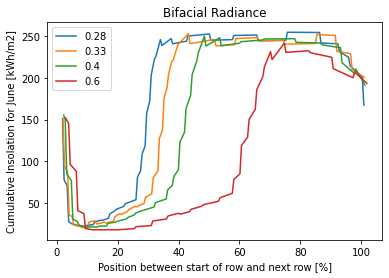

In [21]:
for gc in range (0, len(GCRs)):
    GCR = GCRs[gc]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_'+str(GCR)+'_Ground_Analysis_Front.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    pitch = CW/GCR
    module_end = (2/pitch)*100 #Percentage between rows where the module ends)
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    print(length)
    yinc = -length/(sensorsy_gb[0]-1)
    
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch)*100

    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=GCR)
    plt.title('Bifacial Radiance')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    plt.legend()

## VF and Radiance GCR Percent Difference

In [22]:
for gc in range (0, len(GCRs)):
    GCR = GCRs[gc]
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_'+str(GCR)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 210,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >210000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #Average these for the average for Radiance
    Radave = np.mean(line['Wm2Front'])
    #print('Average Radiance is',Radave)

    #Do the Same for Bifacial VF
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_GCR_'+str(GCR)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Jun'] >210000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Jun'])
    #Find Minimum of plot
    minpointvf=np.min(df['Jun'])
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    Midrvf = Midvf + minpointvf
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Jun'] < Midrvf]
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Jun'])
    #print('Average VF is',VFave)

    Pdif = (Radave-VFave)/((Radave+VFave)/2)*100
    print('For GCR =',GCR,'difference is',Pdif,'%')

For GCR = 0.28 difference is 28.376639752670947 %
For GCR = 0.33 difference is 22.556997626001206 %
For GCR = 0.4 difference is 29.21936128747504 %
For GCR = 0.6 difference is 13.909546176147591 %


## Back of Module GCR Comparison

C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.28_Ground_Analysis_Back.csv
53.87938524157182
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.33_Ground_Analysis_Back.csv
46.30362766581424
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.4_Ground_Analysis_Back.csv
38.87938524157182
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_0.6_Ground_Analysis_Back.csv
27.212718574905153


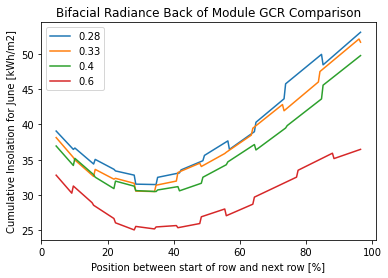

In [23]:
for gc in range (0, len(GCRs)):
    GCR = GCRs[gc]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_GCR_'+str(GCR)+'_Ground_Analysis_Back.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    pitch = CW/GCR
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    print(length)
    yinc = -length/(sensorsy_gb[0]-1)
    
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    
    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/CW)*100

    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=GCR)
    plt.title('Bifacial Radiance Back of Module GCR Comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    plt.legend()

## Part 4 Varying Y Gaps

In [24]:
#Change module orientation to be landscape
xl = 2
yl = 1 
ygaps = [0,.1,.2,.3,.5,1]
numpanels_l = 2
for yg in range (0, len(ygaps)):
     #Build scene and run raytracing for all Ygaps
    ygap = ygaps[yg]
    module = demo.makeModule(name=moduletype, x=xl, y=yl,numpanels = numpanels_l, xgap=xgap, ygap=ygap)
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    pitch = CW/GCR_def
    length = pitch*nRows+(y* np.cos(np.radians(tilt_def)))+2
    yinc = pitch/(sensorsy_gb[0]-1) 
    writefiletitle = os.path.join(testfolder, 'Results_Test_Ygap_'+str(ygap)+'.csv')
    sim_name = sim_general_name+'_Ygap_'+str(ygap)
    sceneDict = {'tilt':tilt_def,'pitch':pitch,'clearance_height':clearance_height_def,'azimuth':azimuth,'nMods': nMods,'nRows': nRows}
    if tilt_def == 20:
        scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
        octfile = demo.makeOct(demo.getfilelist())  
        analysis = bifacial_radiance.AnalysisObj(octfile=octfile, name=sim_name)
        frontscan, backscan = analysis.moduleAnalysis(scene=scene,sensorsx = sensorsx_gb,sensorsy=sensorsy_gb)
        groundscan = frontscan.copy() 
        groundscan['yinc'] = yinc
        groundscan['zstart'] = 0.05
        groundscan['zinc'] = 0
        groundscan['orient'] = '0 0 -1'
    scene = demo.makeScene(moduletype=moduletype,sceneDict=sceneDict, radname = sim_name)
    octfile = demo.makeOct(demo.getfilelist())
    frontscan, backscan = analysis.moduleAnalysis(scene=scene, sensorsy=sensorsy_gb, sensorsx = sensorsx_gb) #Change x and y sensors to match if you want to autogenerate front/back ratio
    analysis.analysis(octfile, name=sim_name+'_Module_Analysis', frontscan=frontscan, backscan=backscan)
    analysis.analysis(octfile, name=sim_name+'_Ground_Analysis', frontscan=groundscan, backscan=backscan)


Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_Ygap_0_Module_Analysis_Front
Linescan in process: Rad_Experiment1_Ygap_0_Module_Analysis_Back
Saved: results\irr_Rad_Experiment1_Ygap_0_Module_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_Ygap_0_Module_Analysis_Back.csv
Linescan in process: Rad_Experiment1_Ygap_0_Ground_Analysis_Front
Linescan in process: Rad_Experiment1_Ygap_0_Ground_Analysis_Back
Saved: results\irr_Rad_Experiment1_Ygap_0_Ground_Analysis_Front.csv
Saved: results\irr_Rad_Experiment1_Ygap_0_Ground_Analysis_Back.csv

Module Name: test-module
Module test-module updated in module.json
Pre-existing .rad file objects\test-module.rad will be overwritten

Created Rad_Experiment1.oct
Created Rad_Experiment1.oct
Linescan in process: Rad_Experiment1_Ygap_0.1_Module_Analysis_Front
Linescan in proc

## Compare ground Irradiances graph

C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0_Ground_Analysis_Front.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.1_Ground_Analysis_Front.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.2_Ground_Analysis_Front.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.3_Ground_Analysis_Front.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.5_Ground_Analysis_Front.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_1_Ground_Analysis_Front.csv


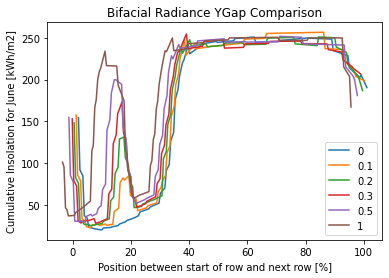

In [25]:
for yg in range (0, len(ygaps)):
    ygap = ygaps[yg]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_'+str(ygap)+'_Ground_Analysis_Front.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    pitch = CW/GCR_def
    
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)

    yshift = data_line_f['y'] + 1 # Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/pitch)*100

    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Front']/1000, label=ygap)
    plt.title('Bifacial Radiance YGap Comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    plt.legend()

## Average Radiance and VF YGap comparison

In [26]:
# The Ygap variation in Radiance is compared to the transmission factor in VF
xl = 2
yl = 1 
ygaps = [0,.1,.2,.3,.5,1]
numpanels_l = 2
for yg in range (0, len(ygaps)):
    ygap = ygaps[yg]
    from bifacialvf import loadVFresults
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_'+str(ygap)+'_Ground_Analysis_Front.csv'
    (data2, metadata) = loadVFresults(Radiance_File)
    data_line = data2 
    data_line_f = data_line[::-1].reset_index(drop = True) 
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Front",}, inplace = True)
    #Isolate rows with Wm2Front values over 220,000
    top = data_line_f.loc[data_line_f['Wm2Front'] >220000]
    #Average rows for average of max
    maxave = np.mean(top['Wm2Front'])
    #Find Minimum of plot
    minpoint=np.min(data_line_f['Wm2Front'])
    #Find midpoint of pot
    Mid = (maxave-minpoint)/2
    Midr = Mid + minpoint
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    line = data_line_f.loc[data_line_f['Wm2Front'] < Midr]
    #print(line)
    #Find last point
    last = line.iloc[0]
    #return row number of the last point
    lp = line[line['y'] == last['y']].index[0]
    #print(lp)
    #Make matrix of all points from 0 to last point
    merge = data_line_f.iloc[lp:]
    #print(merge)
    #Average these for the average for Radiance
    Radave = np.mean(merge['Wm2Front'])
    #print('Average Radiance for', ygap,'is',Radave)

    #Do the Same for Bifacial VF
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    AA = yl*numpanels_l #Area of module that light hits
    transFactor = 1 - (AA/CW) # TransmissionFactor(open area fraction)
    (data, metadata) = loadVFresults(r'C:\Users\jjones\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Experiment_1\Results_Test_TFactor_'+str(transFactor)+'.csv')
    #Work with data in resultfile
    data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
    data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
    groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)
    df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
    # I'm sure there's a fancier way to do this but hey, this works.
    df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",

                       df.columns[4]: "May",df.columns[5]: "Jun",df.columns[6]: "Jul",df.columns[7]: "Aug",
                       df.columns[8]: "Sep",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)
    topvf = df.loc[df['Jun'] >220000]
    #Average rows for average of max
    maxavevf = np.mean(topvf['Jun'])
    #print('Max VF is',maxavevf)
    #Find Minimum of plot
    minpointvf=np.min(df['Jun'])
    #print('Min VF is',minpointvf)
    #Find midpoint of pot
    Midvf = (maxavevf-minpointvf)/2
    Midrvf = Midvf + minpointvf
    #print('Midpoint is',Midvf)
    #Isolate all rows that are below the mid point. There should be two x values corresponding to mid point
    linevf = df.loc[df['Jun'] < Midrvf]
    #print(linevf)
    #Average these for the average for Radiance
    VFave = np.mean(linevf['Jun'])
    #print('Average VF is',VFave)

    Pdif = abs((Radave-VFave)/((Radave+VFave)/2)*100)
    print('For Ygap =',ygap,'difference is',Pdif,'%')

For Ygap = 0 difference is 5.671244128450946 %
For Ygap = 0.1 difference is 4.841410691750116 %
For Ygap = 0.2 difference is 6.817477670552684 %
For Ygap = 0.3 difference is 4.355533845911279 %
For Ygap = 0.5 difference is 0.5046911806275387 %
For Ygap = 1 difference is 1.2059422715915842 %


## Compare Back of Module

C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0_Ground_Analysis_Back.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.1_Ground_Analysis_Back.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.2_Ground_Analysis_Back.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.3_Ground_Analysis_Back.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_0.5_Ground_Analysis_Back.csv
C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_1_Ground_Analysis_Back.csv


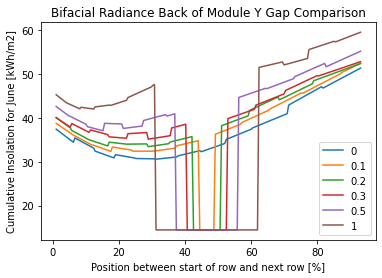

In [27]:
for yg in range (0, len(ygaps)):
    ygap = ygaps[yg]
    from bifacialvf import loadVFresults
    #Change to File Name
    Radiance_File = r'C:\Users\jjones\Documents\GitHub\bifacial_radiance\bifacial_radiance\TEMP\Experiment_1\results\irr_Rad_Experiment1_Ygap_'+str(ygap)+'_Ground_Analysis_Back.csv'
    print(Radiance_File)
    (data2, metadata) = loadVFresults(Radiance_File)
    
    CW = yl * numpanels_l +(ygap * (numpanels_l-1)) #Collector Width
    pitch = CW/GCR_def
    
    data_line = data2
    data_line_f = data_line[::-1].reset_index(drop = True) #Flip the column
    data_line_f.rename(columns={ data_line_f.columns[0]: "x", data_line_f.columns[1]: "y",data_line_f.columns[2]: "z", data_line_f.columns[3]: "mattype",data_line_f.columns[4]: "Wm2Back",}, inplace = True)
    
    yshift = data_line_f['y'] + abs(float(data_line_f['y'].iloc[[0]]))# Shift x_axis so it starts at 0 and not -1
    ystep = (yshift/CW)*100

    plt.figure(1)
    Radiance = plt.plot(ystep,data_line_f['Wm2Back']/1000, label=ygap)
    plt.title('Bifacial Radiance Back of Module Y Gap Comparison')
    plt.xlabel('Position between start of row and next row [%]')
    plt.ylabel('Cumulative Insolation for June [kWh/m2]')
    plt.legend()

<a id='step5c'></a>